In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
mnist_train = torchvision.datasets.MNIST(".", train=True, download=True, transform=mnist_transform)
mnist_test = torchvision.datasets.MNIST(".", train=False, download=True, transform=mnist_transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 60.2MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
from torch.utils.data import random_split

In [5]:
# Define split ratios
train_size = int(0.8 * len(mnist_train))
val_size = int(0.2 * len(mnist_train))

# Split dataset
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

In [6]:
from torch.utils.data import DataLoader

In [7]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

pred_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
def _weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
import torch.nn.utils.spectral_norm as spectral_norm

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            spectral_norm(nn.ConvTranspose2d(100, 1024, 3, 1, 0, bias=False)),
            nn.ReLU(True),

            spectral_norm(nn.ConvTranspose2d(1024, 512, 3, 2, 0, bias=False)),
            nn.ReLU(True),

            spectral_norm(nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        ])

        self.apply(_weights_init)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1) # [batch_size, 100] => [batch_size, 100, 1, 1]
        for layer in self.layers:
            x = layer(x)
        return x

In [12]:
generator = Generator()

In [13]:
class Discrimiator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(1, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(512, 1024, 3, 2, 0, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, 3, 1, 0, bias=False),
        ])

        self.apply(_weights_init)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.view(x.shape[0], -1)

In [14]:
adv = Discrimiator()

In [15]:
import torch.nn.functional as F

def adversarialLoss(d_x, d_g_z, gp, lambda_gp):
    return -d_x.mean() + d_g_z.mean() + lambda_gp * gp

def generatorLoss(d_g_z):
    return -d_g_z.mean()

In [16]:
def gradientPenalty(real_data, gen_data, adv):
    epsilon = torch.randn((batch_size, 1, 1, 1)).repeat(1, 1, 28, 28).to(device)
        
    interpolated_img = epsilon * real_data + (1 - epsilon) * gen_data
    # print(f"gen_data: {noise}")
    # print(f"gen_data.shape: {gen_data.shape}")
    
    pred_interpolated_data = adv(interpolated_img)
    # print(f"pred_gen_data: {pred_gen_data}")
    # print(f"pred_gen_data.shape: {pred_gen_data.shape}")

    # loss
    gradient = torch.autograd.grad(
        inputs = interpolated_img,
        outputs = pred_interpolated_data,
        grad_outputs = torch.ones_like(pred_interpolated_data),
        create_graph = True,
        retain_graph = True
    )[0] # d(pred_interpolated_data) / d(interpolated_img)

    gradient = gradient.view(gradient.shape[0], -1) # flatten with graident.shape[0] being num of examples
    gradient_norm = gradient.norm(2, dim=1) # dim is 1 with data
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

In [17]:
len(train_loader)

1500

In [18]:
import math
import itertools

In [19]:
import matplotlib.pyplot as plt

torch.Size([1, 1, 28, 28])


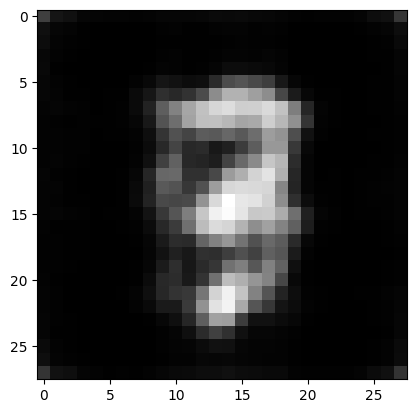

Epoch 100/10000, Adversial Loss: -20.6712, Generator Loss: -9.4404
torch.Size([1, 1, 28, 28])


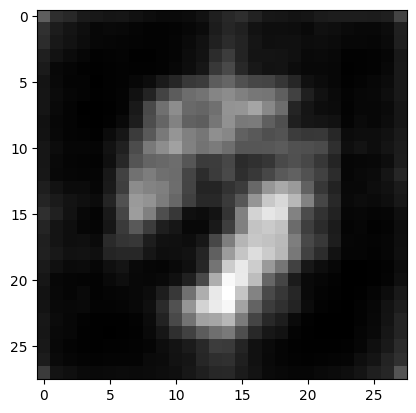

Epoch 200/10000, Adversial Loss: -15.5563, Generator Loss: -5.9164
torch.Size([1, 1, 28, 28])


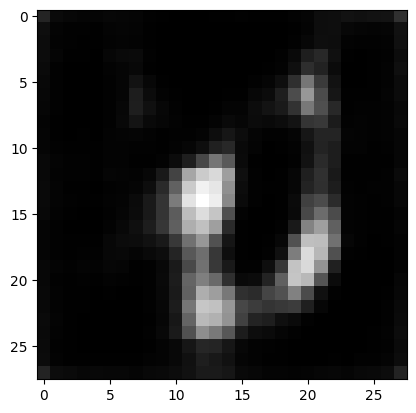

Epoch 300/10000, Adversial Loss: -12.8286, Generator Loss: -6.2663
torch.Size([1, 1, 28, 28])


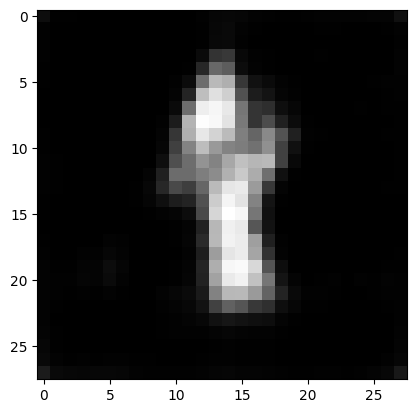

Epoch 400/10000, Adversial Loss: -9.8830, Generator Loss: -8.5883
torch.Size([1, 1, 28, 28])


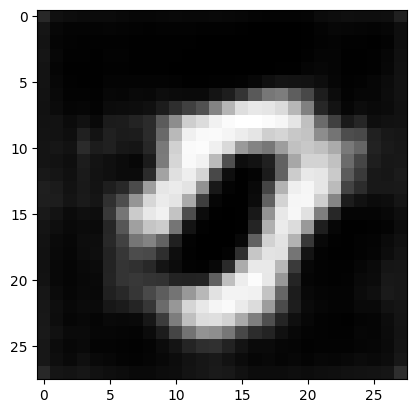

Epoch 500/10000, Adversial Loss: -9.6999, Generator Loss: 1.4191
torch.Size([1, 1, 28, 28])


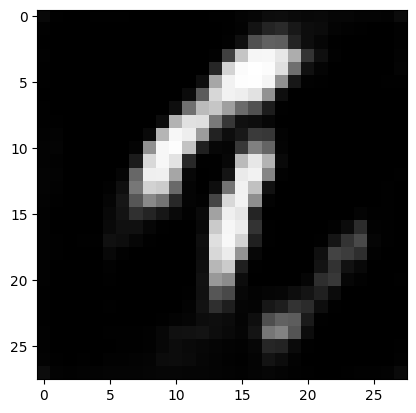

Epoch 600/10000, Adversial Loss: -7.1263, Generator Loss: -0.1534
torch.Size([1, 1, 28, 28])


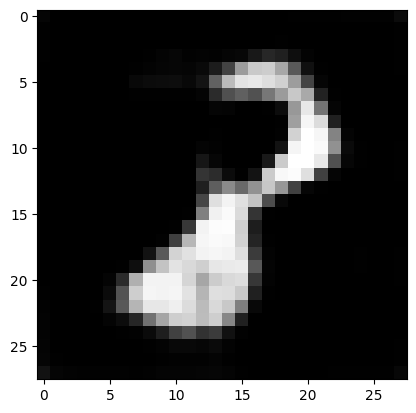

Epoch 700/10000, Adversial Loss: -5.6516, Generator Loss: -2.6383
torch.Size([1, 1, 28, 28])


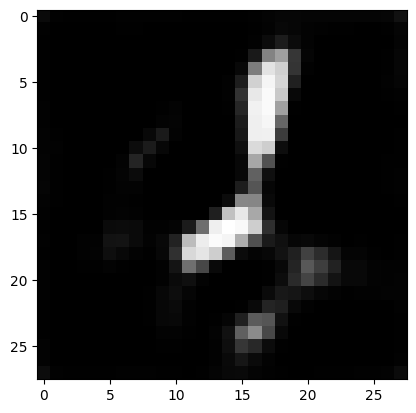

Epoch 800/10000, Adversial Loss: -4.8701, Generator Loss: -5.5266
torch.Size([1, 1, 28, 28])


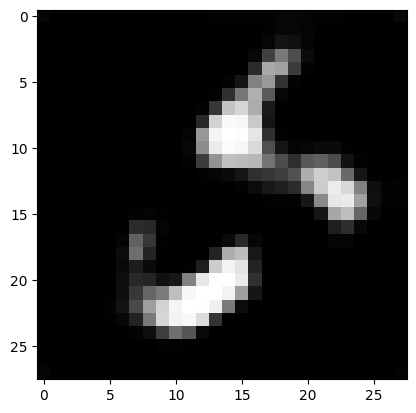

Epoch 900/10000, Adversial Loss: -5.6478, Generator Loss: -10.2998
torch.Size([1, 1, 28, 28])


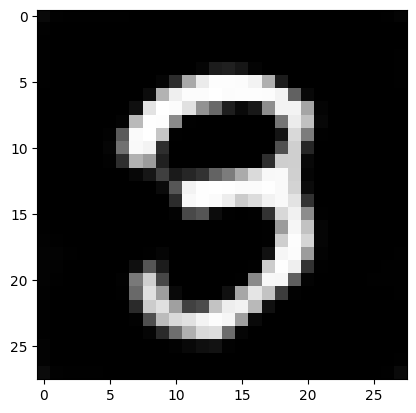

Epoch 1000/10000, Adversial Loss: -4.1523, Generator Loss: -5.2441
torch.Size([1, 1, 28, 28])


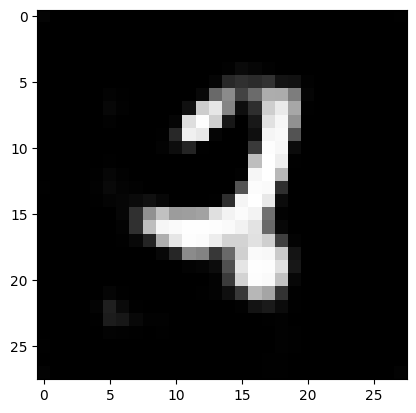

Epoch 1100/10000, Adversial Loss: -3.4524, Generator Loss: -5.9842
torch.Size([1, 1, 28, 28])


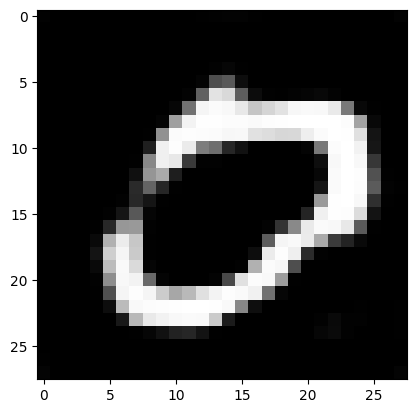

Epoch 1200/10000, Adversial Loss: -4.2201, Generator Loss: -2.2742
torch.Size([1, 1, 28, 28])


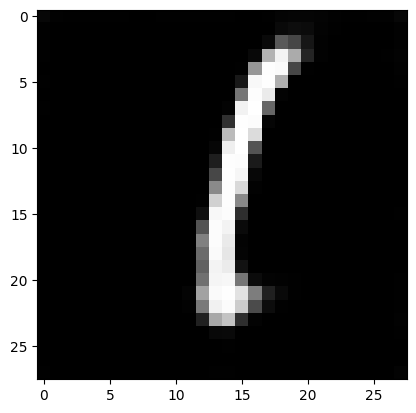

Epoch 1300/10000, Adversial Loss: -3.9670, Generator Loss: -3.0404
torch.Size([1, 1, 28, 28])


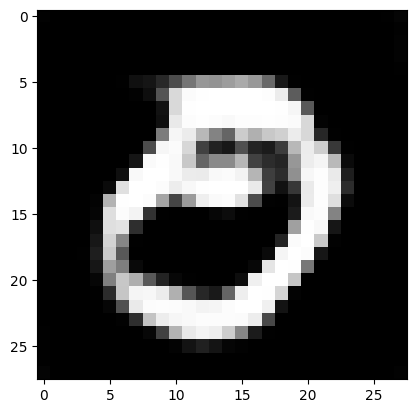

Epoch 1400/10000, Adversial Loss: -3.1749, Generator Loss: -2.4348
torch.Size([1, 1, 28, 28])


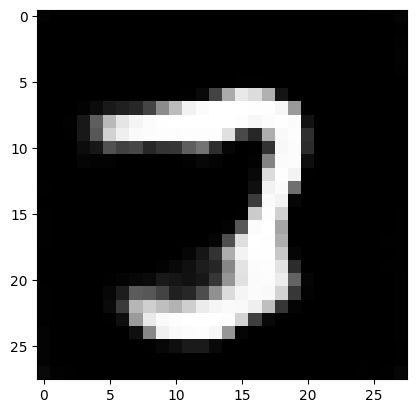

Epoch 1500/10000, Adversial Loss: -2.5447, Generator Loss: -2.5165
torch.Size([1, 1, 28, 28])


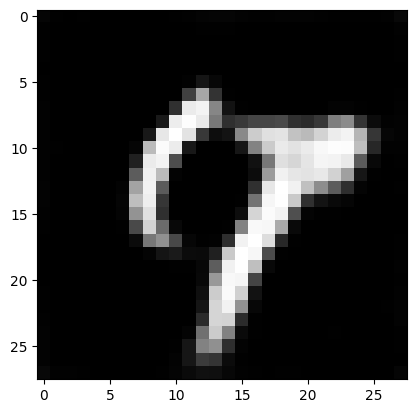

Epoch 1600/10000, Adversial Loss: -3.0194, Generator Loss: 0.0331
torch.Size([1, 1, 28, 28])


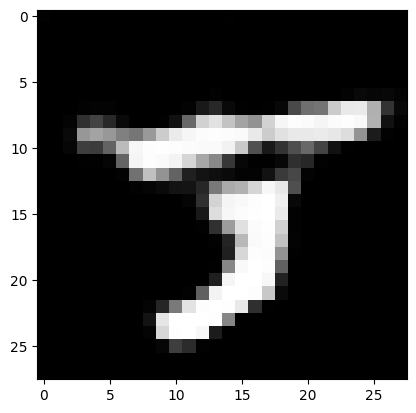

Epoch 1700/10000, Adversial Loss: -4.3332, Generator Loss: 0.2601
torch.Size([1, 1, 28, 28])


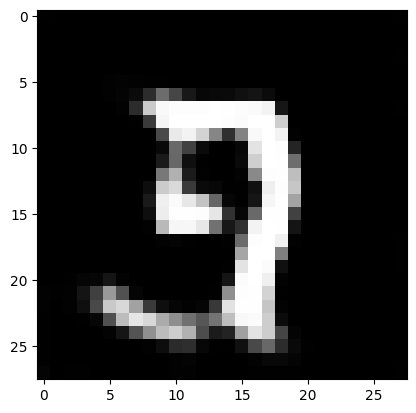

Epoch 1800/10000, Adversial Loss: -3.7444, Generator Loss: -0.1570
torch.Size([1, 1, 28, 28])


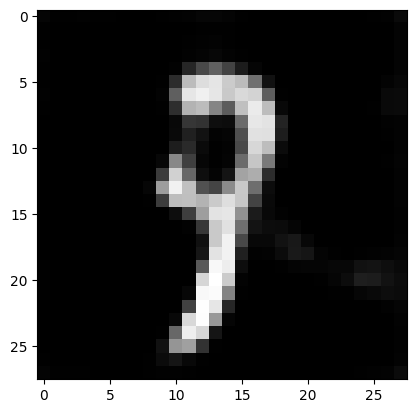

Epoch 1900/10000, Adversial Loss: -4.3649, Generator Loss: -4.1127
torch.Size([1, 1, 28, 28])


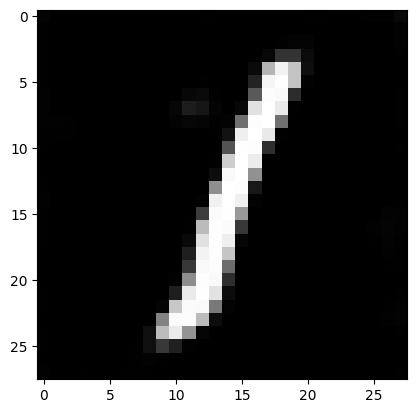

Epoch 2000/10000, Adversial Loss: -3.5506, Generator Loss: -1.1981
torch.Size([1, 1, 28, 28])


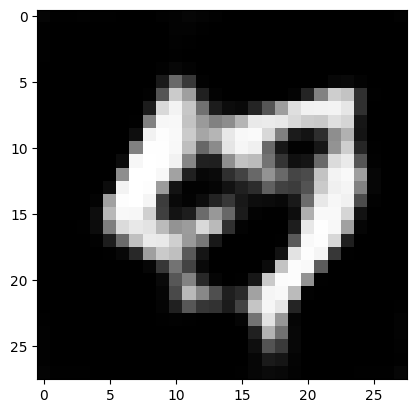

Epoch 2100/10000, Adversial Loss: -3.3208, Generator Loss: 0.5018
torch.Size([1, 1, 28, 28])


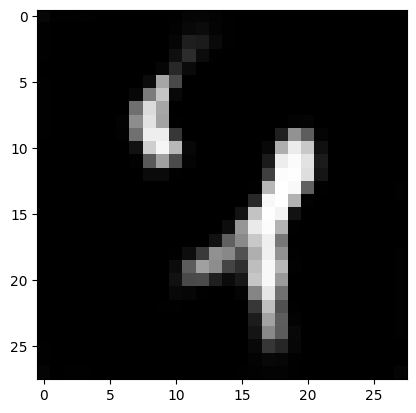

Epoch 2200/10000, Adversial Loss: -3.1014, Generator Loss: -4.8820
torch.Size([1, 1, 28, 28])


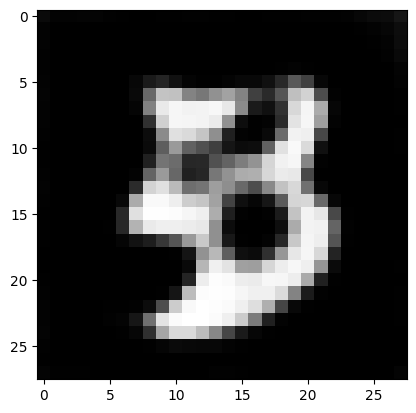

Epoch 2300/10000, Adversial Loss: -2.4366, Generator Loss: -0.9008
torch.Size([1, 1, 28, 28])


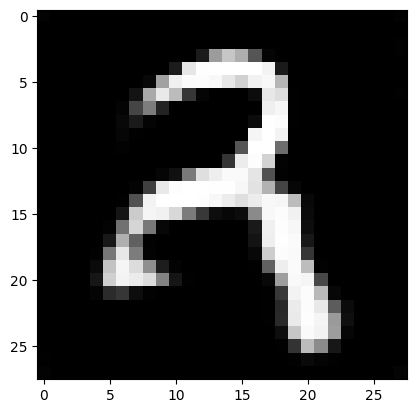

Epoch 2400/10000, Adversial Loss: -2.9208, Generator Loss: -2.2374
torch.Size([1, 1, 28, 28])


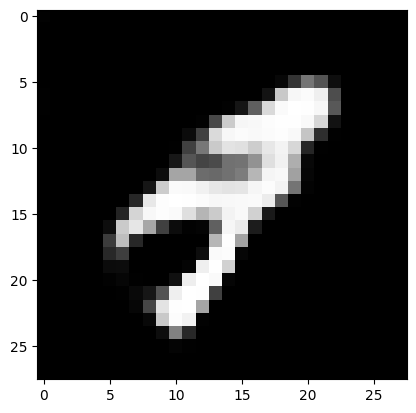

Epoch 2500/10000, Adversial Loss: -3.2161, Generator Loss: -4.2178
torch.Size([1, 1, 28, 28])


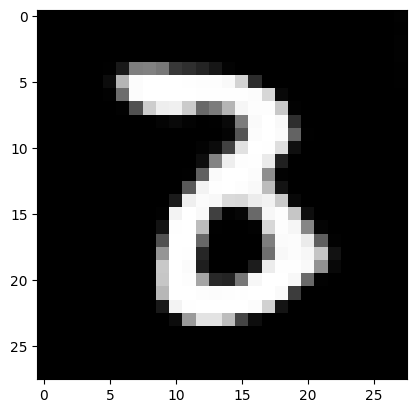

Epoch 2600/10000, Adversial Loss: -3.4584, Generator Loss: -0.2880
torch.Size([1, 1, 28, 28])


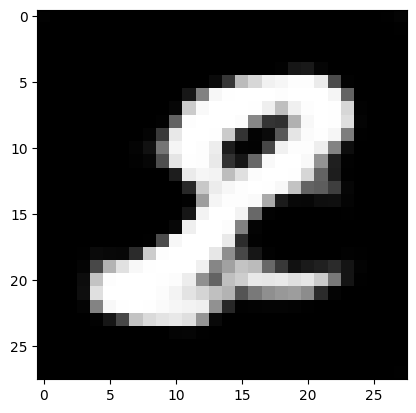

Epoch 2700/10000, Adversial Loss: -2.4682, Generator Loss: -2.1443
torch.Size([1, 1, 28, 28])


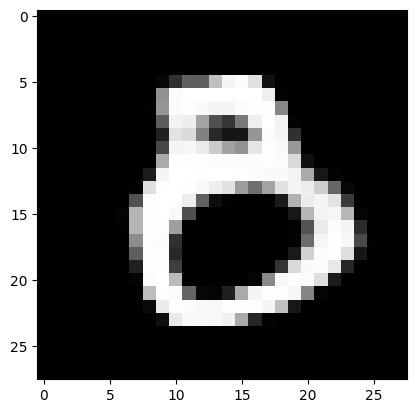

Epoch 2800/10000, Adversial Loss: -3.3690, Generator Loss: -2.0564
torch.Size([1, 1, 28, 28])


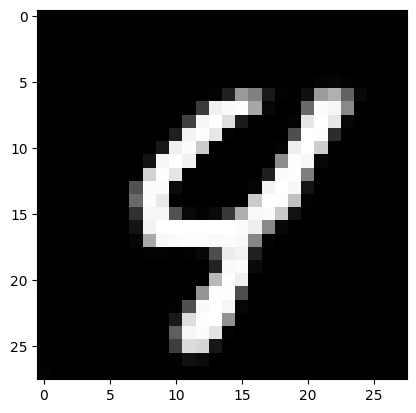

Epoch 2900/10000, Adversial Loss: -3.4777, Generator Loss: 0.2784
torch.Size([1, 1, 28, 28])


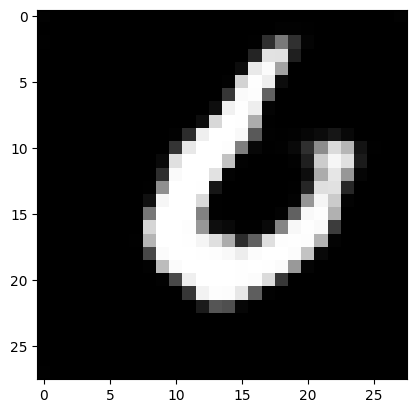

Epoch 3000/10000, Adversial Loss: -2.0867, Generator Loss: -1.9067
torch.Size([1, 1, 28, 28])


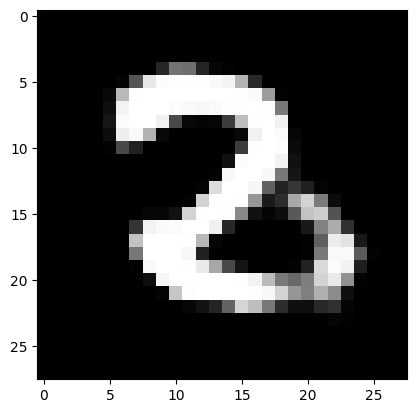

Epoch 3100/10000, Adversial Loss: -3.1729, Generator Loss: -3.1714
torch.Size([1, 1, 28, 28])


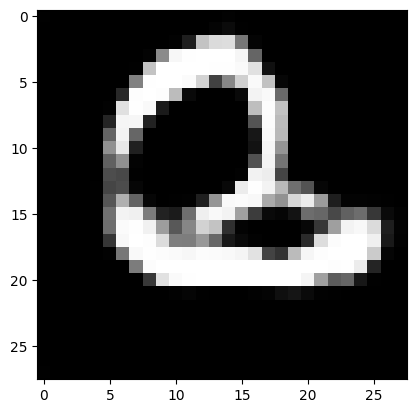

Epoch 3200/10000, Adversial Loss: -3.5990, Generator Loss: -2.7527
torch.Size([1, 1, 28, 28])


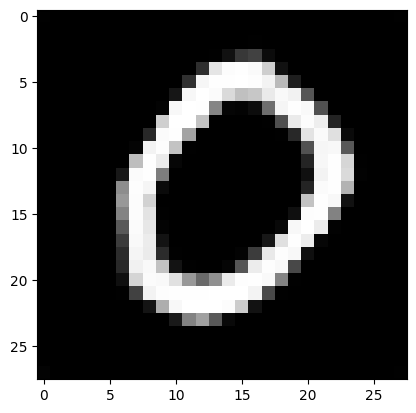

Epoch 3300/10000, Adversial Loss: -2.5306, Generator Loss: -2.8114
torch.Size([1, 1, 28, 28])


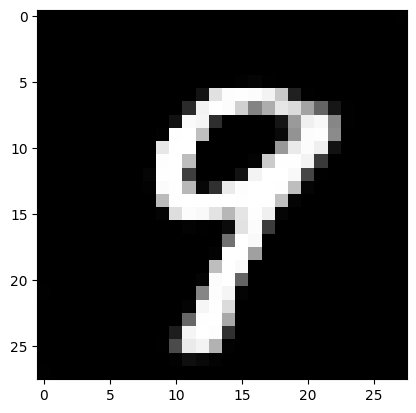

Epoch 3400/10000, Adversial Loss: -1.9621, Generator Loss: -1.7816
torch.Size([1, 1, 28, 28])


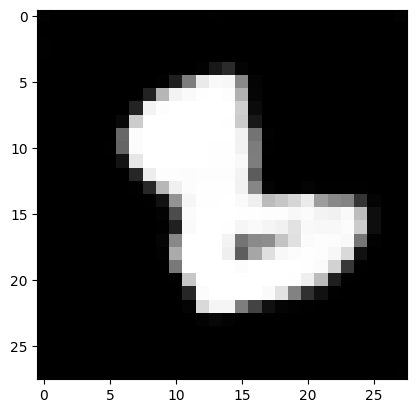

Epoch 3500/10000, Adversial Loss: -3.8149, Generator Loss: -0.5664
torch.Size([1, 1, 28, 28])


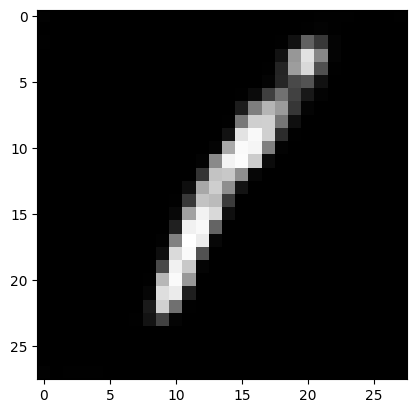

Epoch 3600/10000, Adversial Loss: -3.0901, Generator Loss: -1.6662
torch.Size([1, 1, 28, 28])


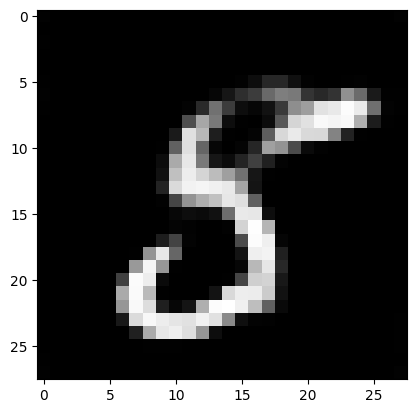

Epoch 3700/10000, Adversial Loss: -2.6561, Generator Loss: -2.0551
torch.Size([1, 1, 28, 28])


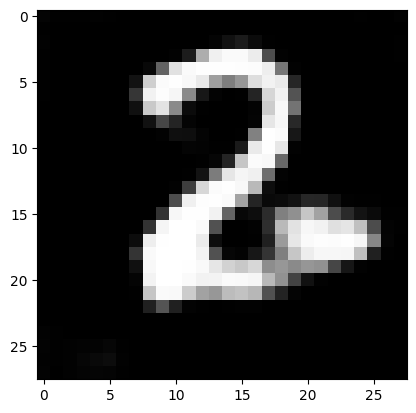

Epoch 3800/10000, Adversial Loss: -2.6776, Generator Loss: -1.1152
torch.Size([1, 1, 28, 28])


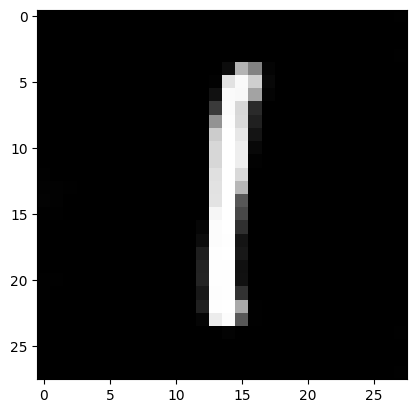

Epoch 3900/10000, Adversial Loss: -2.5334, Generator Loss: -2.1071
torch.Size([1, 1, 28, 28])


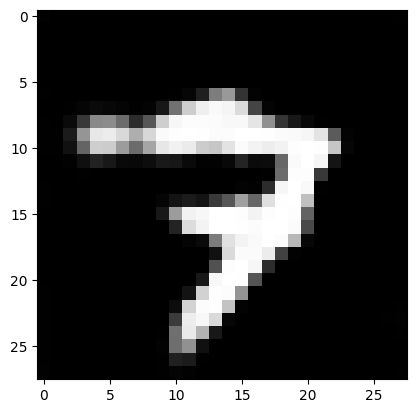

Epoch 4000/10000, Adversial Loss: -2.4735, Generator Loss: -2.7659
torch.Size([1, 1, 28, 28])


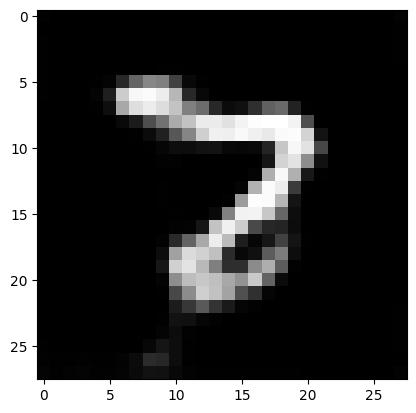

Epoch 4100/10000, Adversial Loss: -2.7113, Generator Loss: -1.9347
torch.Size([1, 1, 28, 28])


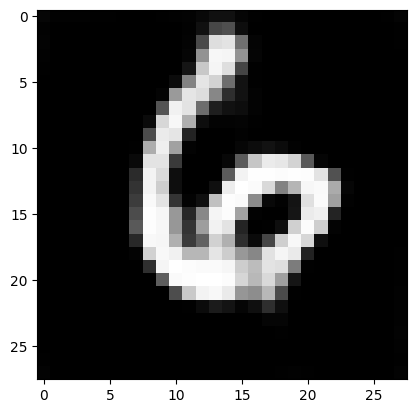

Epoch 4200/10000, Adversial Loss: -2.2276, Generator Loss: -2.1430
torch.Size([1, 1, 28, 28])


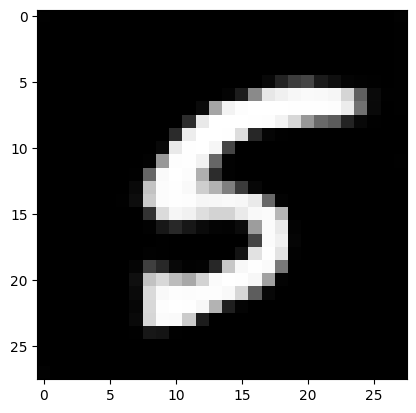

Epoch 4300/10000, Adversial Loss: -2.6834, Generator Loss: -3.1664
torch.Size([1, 1, 28, 28])


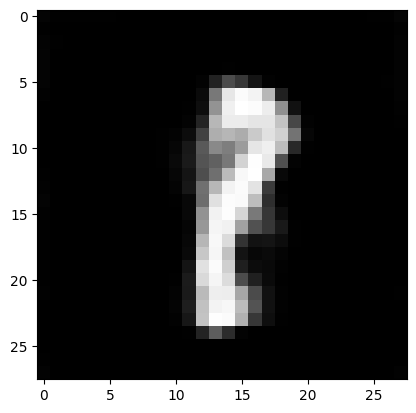

Epoch 4400/10000, Adversial Loss: -2.2962, Generator Loss: -2.8005
torch.Size([1, 1, 28, 28])


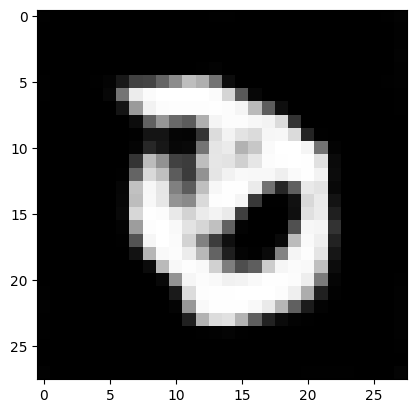

Epoch 4500/10000, Adversial Loss: -2.9519, Generator Loss: -0.9057
torch.Size([1, 1, 28, 28])


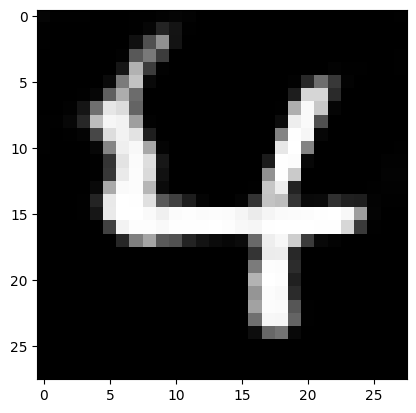

Epoch 4600/10000, Adversial Loss: -2.0014, Generator Loss: -3.0676
torch.Size([1, 1, 28, 28])


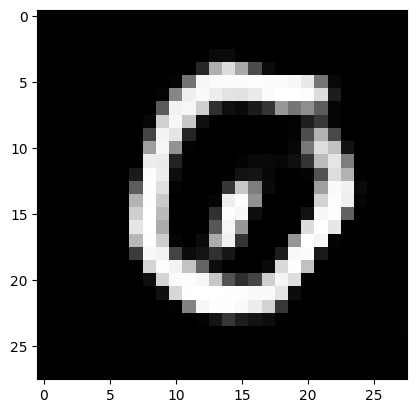

Epoch 4700/10000, Adversial Loss: -3.2134, Generator Loss: -1.4283
torch.Size([1, 1, 28, 28])


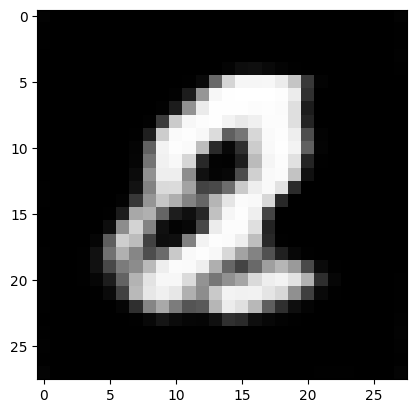

Epoch 4800/10000, Adversial Loss: -3.1134, Generator Loss: -2.4662
torch.Size([1, 1, 28, 28])


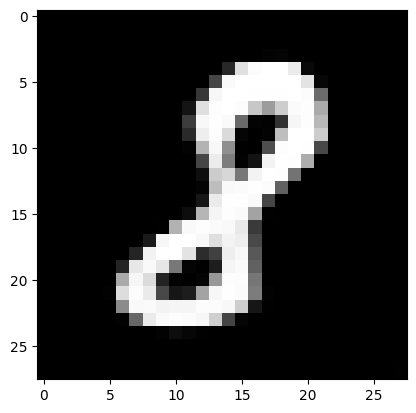

Epoch 4900/10000, Adversial Loss: -2.3266, Generator Loss: -3.0983
torch.Size([1, 1, 28, 28])


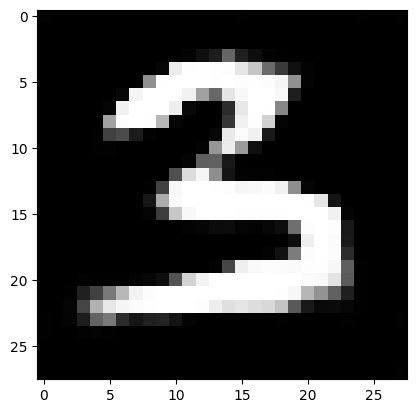

Epoch 5000/10000, Adversial Loss: -1.8737, Generator Loss: -1.4400
torch.Size([1, 1, 28, 28])


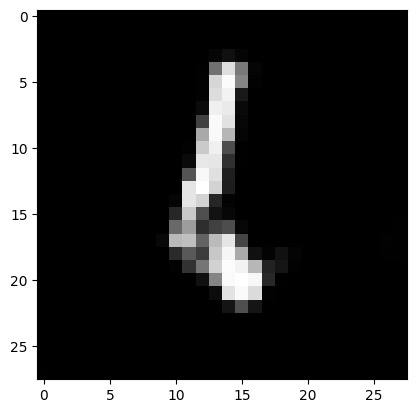

Epoch 5100/10000, Adversial Loss: -2.1403, Generator Loss: -3.6917
torch.Size([1, 1, 28, 28])


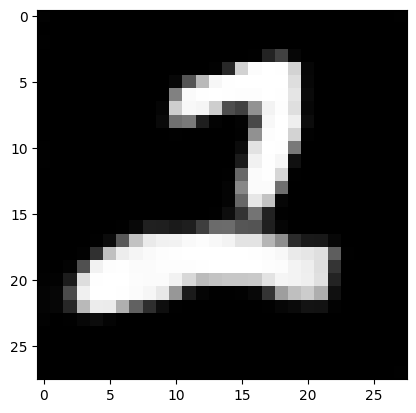

Epoch 5200/10000, Adversial Loss: -1.8333, Generator Loss: -2.9789
torch.Size([1, 1, 28, 28])


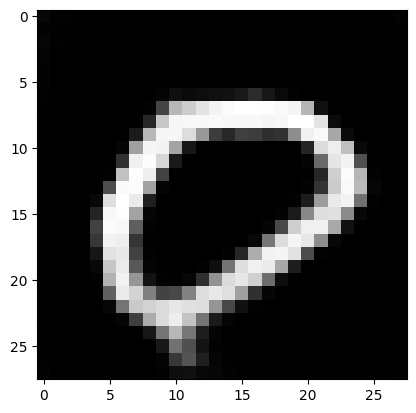

Epoch 5300/10000, Adversial Loss: -2.1203, Generator Loss: -3.1782
torch.Size([1, 1, 28, 28])


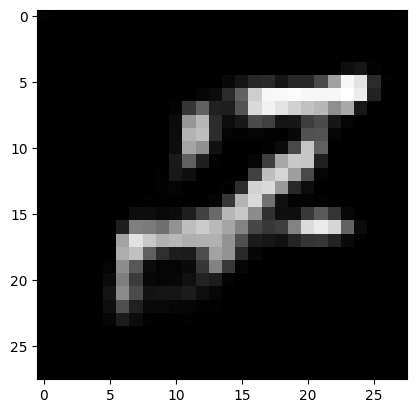

Epoch 5400/10000, Adversial Loss: -2.3583, Generator Loss: -1.6888
torch.Size([1, 1, 28, 28])


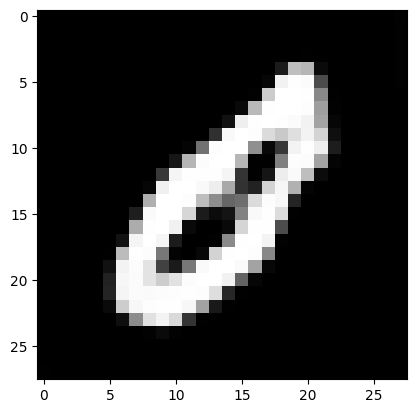

Epoch 5500/10000, Adversial Loss: -1.7574, Generator Loss: -2.4883
torch.Size([1, 1, 28, 28])


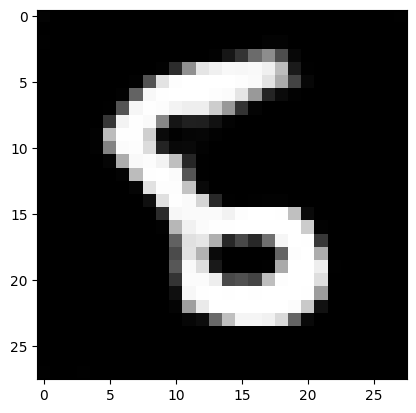

Epoch 5600/10000, Adversial Loss: -2.9843, Generator Loss: -1.4545
torch.Size([1, 1, 28, 28])


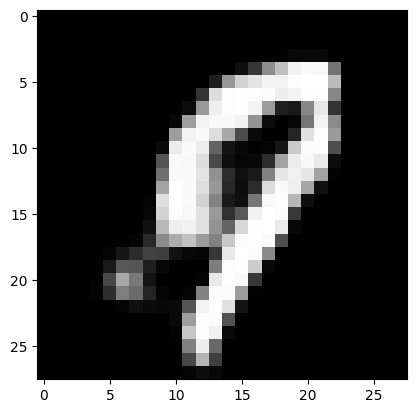

Epoch 5700/10000, Adversial Loss: -2.3594, Generator Loss: -1.8981
torch.Size([1, 1, 28, 28])


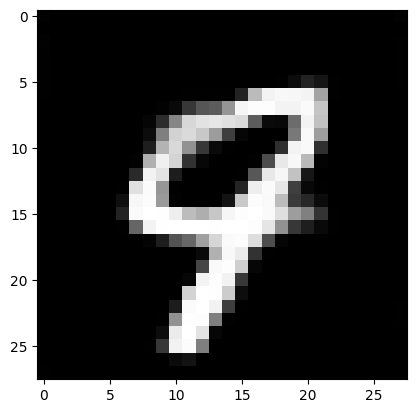

Epoch 5800/10000, Adversial Loss: -2.0999, Generator Loss: -1.8831
torch.Size([1, 1, 28, 28])


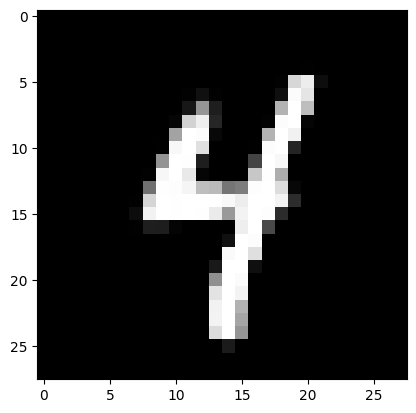

Epoch 5900/10000, Adversial Loss: -1.7365, Generator Loss: -3.1783
torch.Size([1, 1, 28, 28])


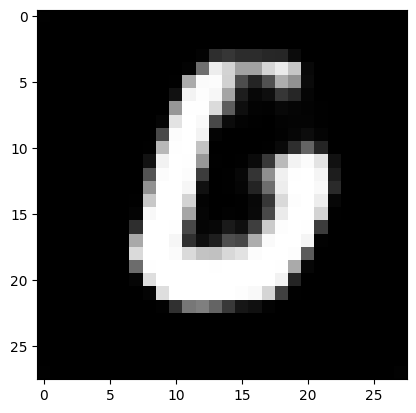

Epoch 6000/10000, Adversial Loss: -1.6298, Generator Loss: -1.7814
torch.Size([1, 1, 28, 28])


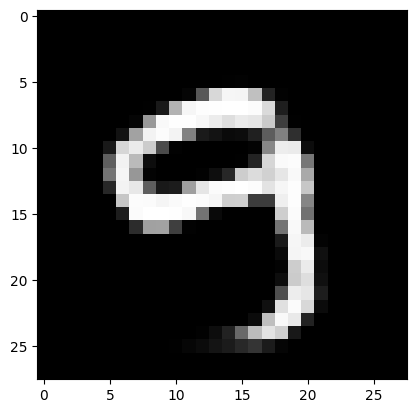

Epoch 6100/10000, Adversial Loss: -2.2874, Generator Loss: -3.1829
torch.Size([1, 1, 28, 28])


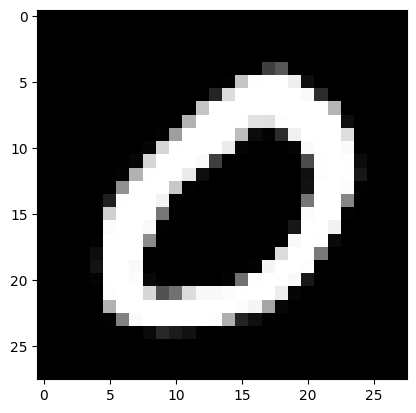

Epoch 6200/10000, Adversial Loss: -2.6501, Generator Loss: -3.5056
torch.Size([1, 1, 28, 28])


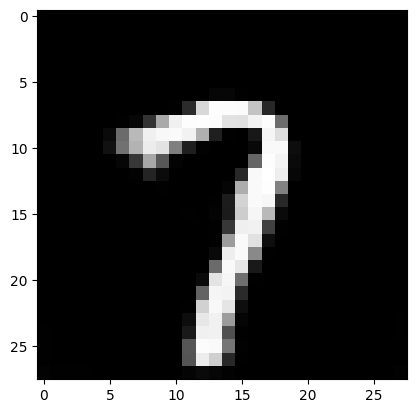

Epoch 6300/10000, Adversial Loss: -2.9007, Generator Loss: -2.0406
torch.Size([1, 1, 28, 28])


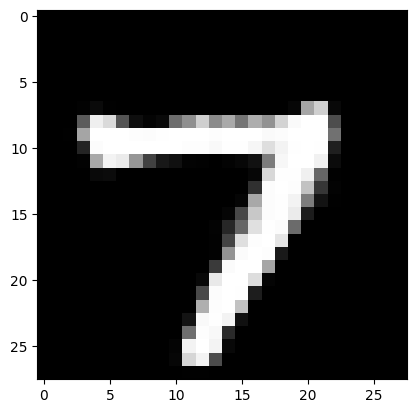

Epoch 6400/10000, Adversial Loss: -1.5759, Generator Loss: -3.1953
torch.Size([1, 1, 28, 28])


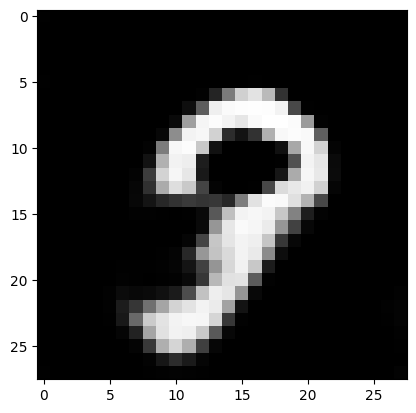

Epoch 6500/10000, Adversial Loss: -1.9348, Generator Loss: -2.5011
torch.Size([1, 1, 28, 28])


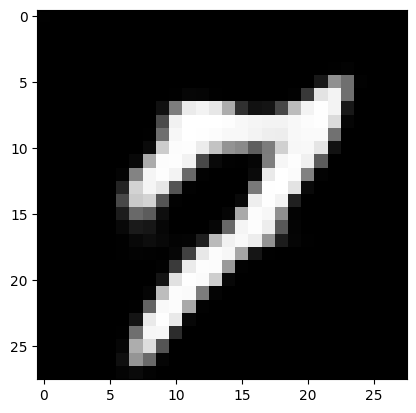

Epoch 6600/10000, Adversial Loss: -1.8480, Generator Loss: -1.5306
torch.Size([1, 1, 28, 28])


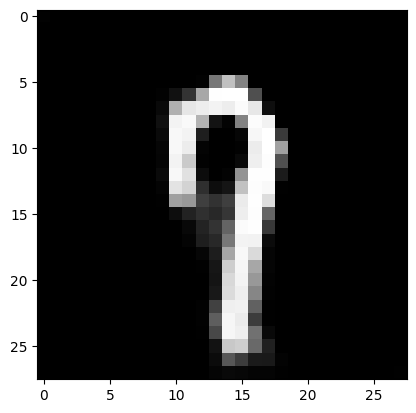

Epoch 6700/10000, Adversial Loss: -2.0141, Generator Loss: -4.5572
torch.Size([1, 1, 28, 28])


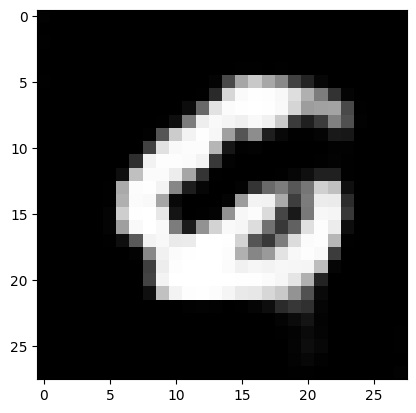

Epoch 6800/10000, Adversial Loss: -1.7497, Generator Loss: -2.8000
torch.Size([1, 1, 28, 28])


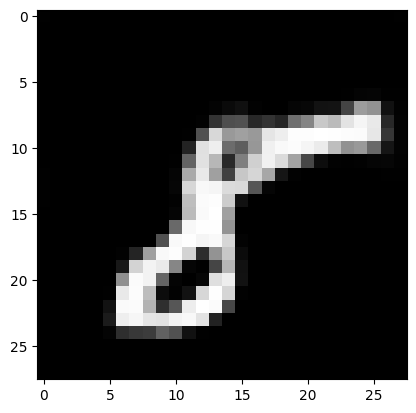

Epoch 6900/10000, Adversial Loss: -1.0902, Generator Loss: -1.9811
torch.Size([1, 1, 28, 28])


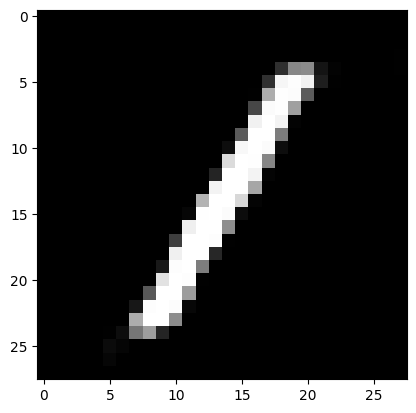

Epoch 7000/10000, Adversial Loss: -2.8040, Generator Loss: -2.8292
torch.Size([1, 1, 28, 28])


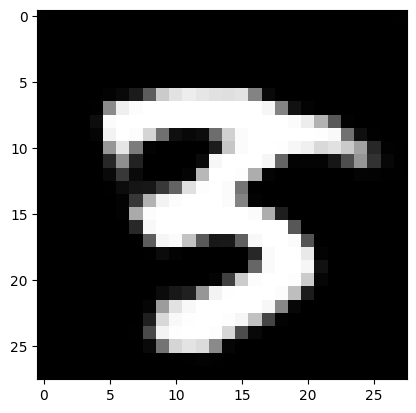

Epoch 7100/10000, Adversial Loss: -0.7030, Generator Loss: -3.1662
torch.Size([1, 1, 28, 28])


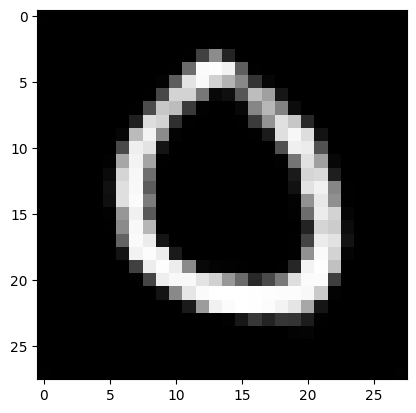

Epoch 7200/10000, Adversial Loss: -2.6301, Generator Loss: -2.7002
torch.Size([1, 1, 28, 28])


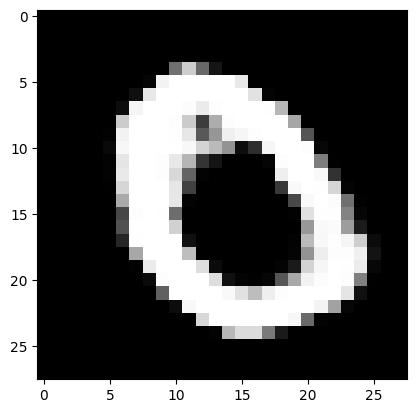

Epoch 7300/10000, Adversial Loss: -2.0597, Generator Loss: -2.1483
torch.Size([1, 1, 28, 28])


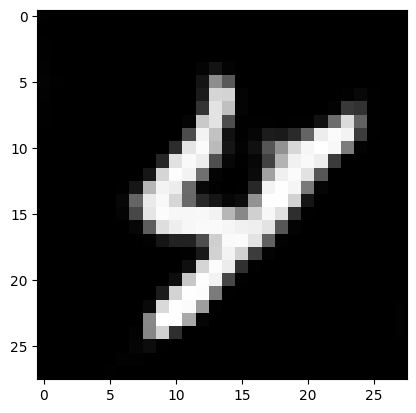

Epoch 7400/10000, Adversial Loss: -2.3496, Generator Loss: -2.2594
torch.Size([1, 1, 28, 28])


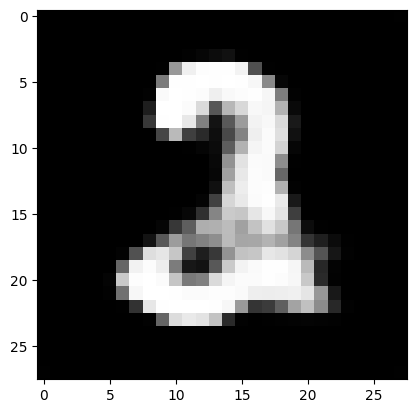

Epoch 7500/10000, Adversial Loss: -2.7263, Generator Loss: -2.4071
torch.Size([1, 1, 28, 28])


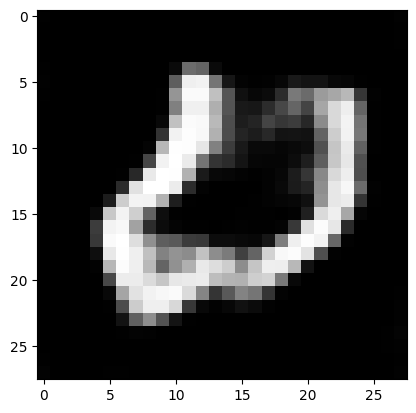

Epoch 7600/10000, Adversial Loss: -2.0254, Generator Loss: -0.4529
torch.Size([1, 1, 28, 28])


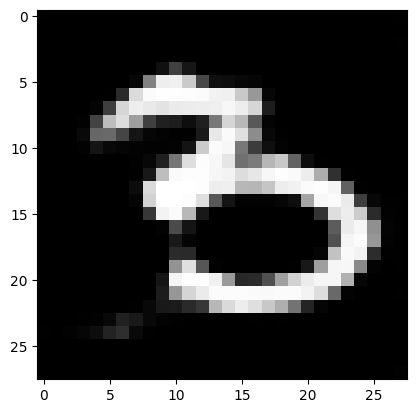

Epoch 7700/10000, Adversial Loss: -2.4957, Generator Loss: -3.7080
torch.Size([1, 1, 28, 28])


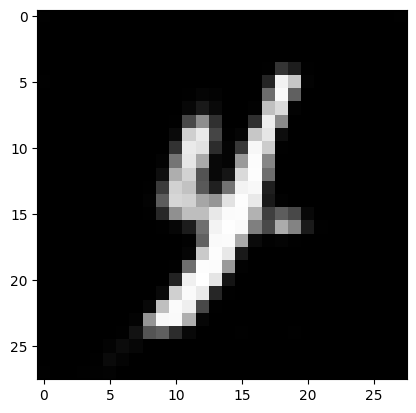

Epoch 7800/10000, Adversial Loss: -1.9178, Generator Loss: -2.5273
torch.Size([1, 1, 28, 28])


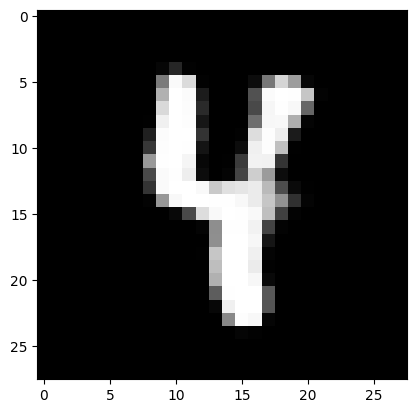

Epoch 7900/10000, Adversial Loss: -2.6739, Generator Loss: -3.1261
torch.Size([1, 1, 28, 28])


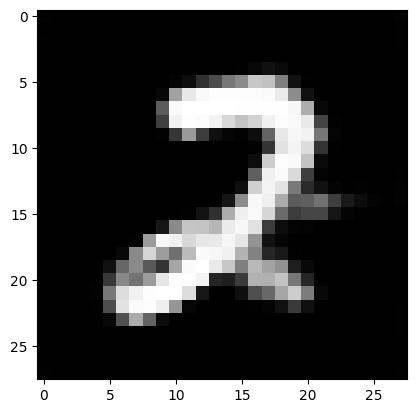

Epoch 8000/10000, Adversial Loss: -1.8787, Generator Loss: -3.2658
torch.Size([1, 1, 28, 28])


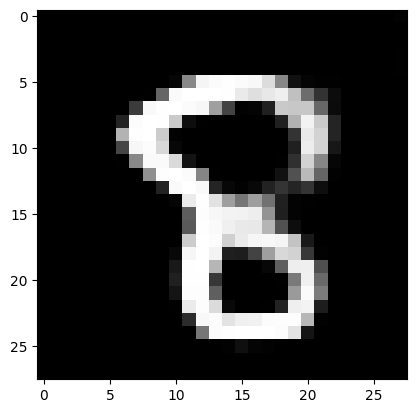

Epoch 8100/10000, Adversial Loss: -1.6959, Generator Loss: -0.8225
torch.Size([1, 1, 28, 28])


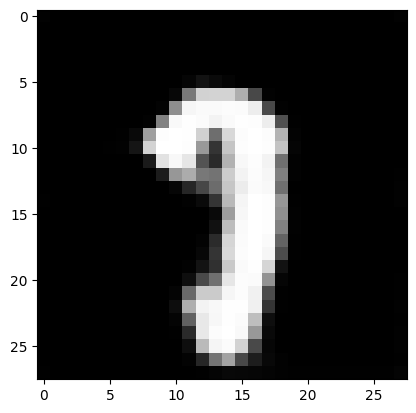

Epoch 8200/10000, Adversial Loss: -1.8457, Generator Loss: -3.6276
torch.Size([1, 1, 28, 28])


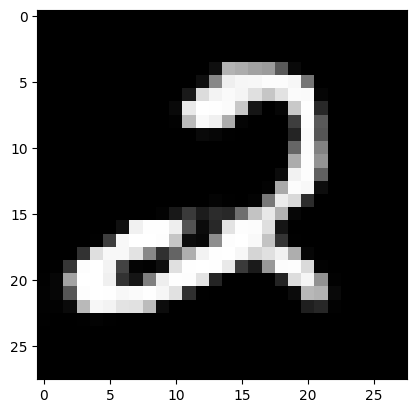

Epoch 8300/10000, Adversial Loss: -1.2867, Generator Loss: -3.0464
torch.Size([1, 1, 28, 28])


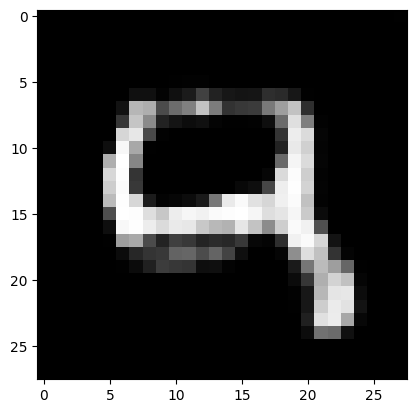

Epoch 8400/10000, Adversial Loss: -1.8877, Generator Loss: -2.0052
torch.Size([1, 1, 28, 28])


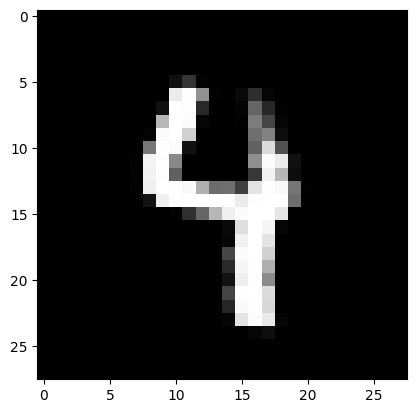

Epoch 8500/10000, Adversial Loss: -2.3878, Generator Loss: -2.9132
torch.Size([1, 1, 28, 28])


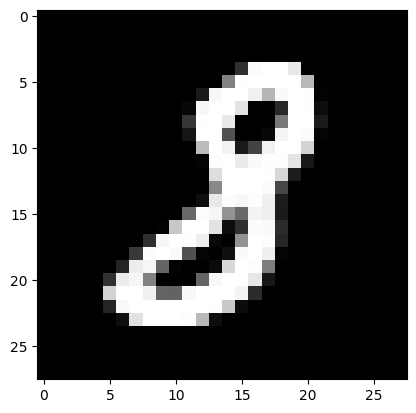

Epoch 8600/10000, Adversial Loss: -1.6663, Generator Loss: -2.4534
torch.Size([1, 1, 28, 28])


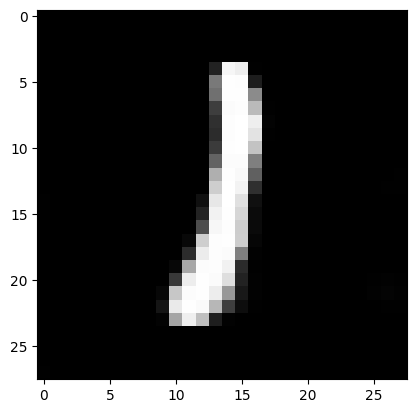

Epoch 8700/10000, Adversial Loss: -1.7838, Generator Loss: -2.7505
torch.Size([1, 1, 28, 28])


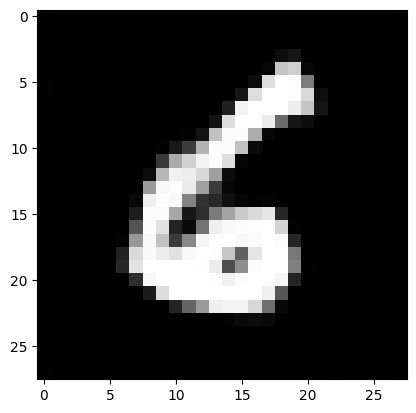

Epoch 8800/10000, Adversial Loss: -1.6394, Generator Loss: -4.1544
torch.Size([1, 1, 28, 28])


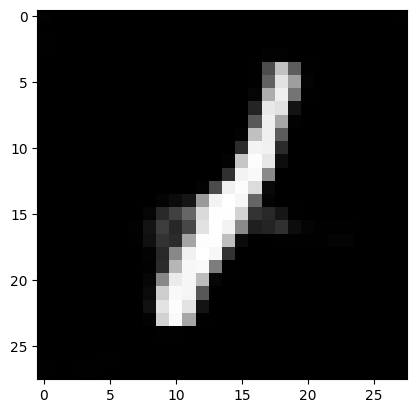

Epoch 8900/10000, Adversial Loss: -1.3989, Generator Loss: -3.2664
torch.Size([1, 1, 28, 28])


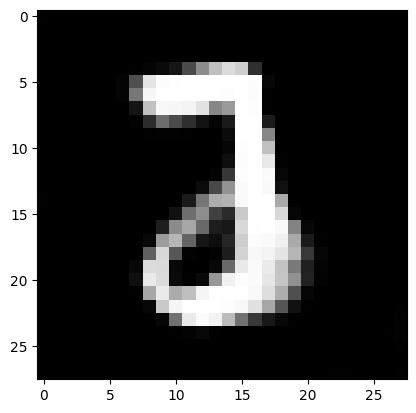

Epoch 9000/10000, Adversial Loss: -2.2073, Generator Loss: -1.6074
torch.Size([1, 1, 28, 28])


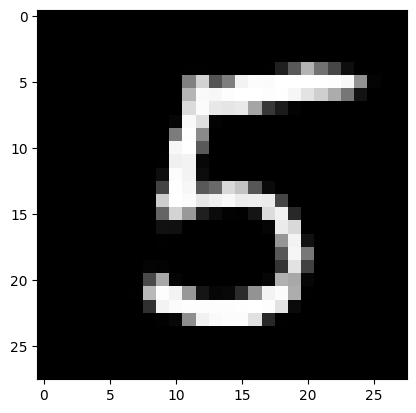

Epoch 9100/10000, Adversial Loss: -1.4349, Generator Loss: -2.9671
torch.Size([1, 1, 28, 28])


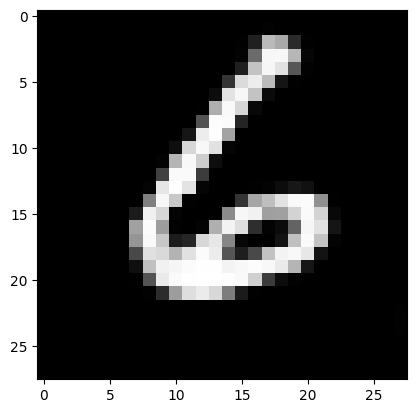

Epoch 9200/10000, Adversial Loss: -1.8944, Generator Loss: -4.6657
torch.Size([1, 1, 28, 28])


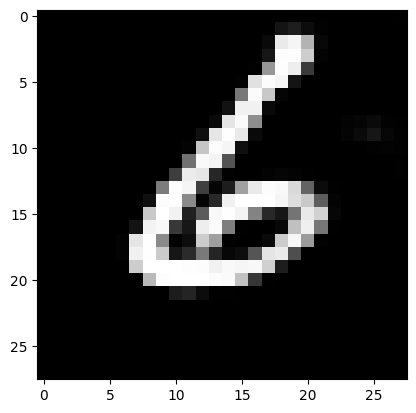

Epoch 9300/10000, Adversial Loss: -1.8912, Generator Loss: -2.5693
torch.Size([1, 1, 28, 28])


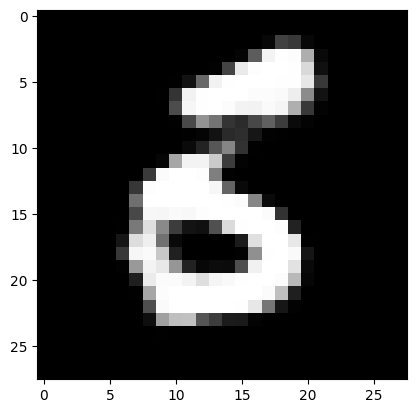

Epoch 9400/10000, Adversial Loss: -1.8793, Generator Loss: -1.9984
torch.Size([1, 1, 28, 28])


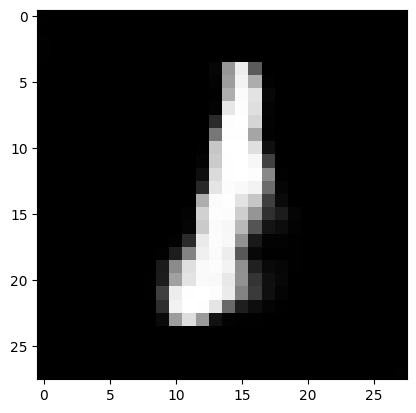

Epoch 9500/10000, Adversial Loss: -2.9734, Generator Loss: -3.3931
torch.Size([1, 1, 28, 28])


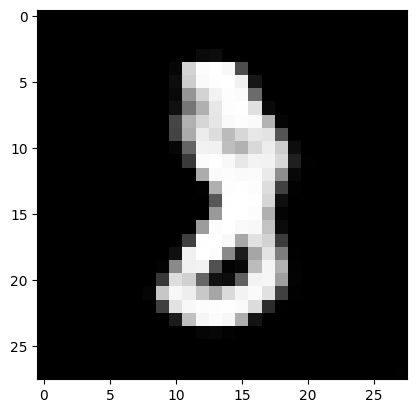

Epoch 9600/10000, Adversial Loss: -2.0540, Generator Loss: -3.2406
torch.Size([1, 1, 28, 28])


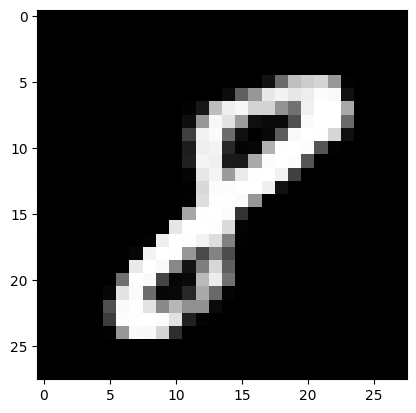

Epoch 9700/10000, Adversial Loss: -1.4848, Generator Loss: -3.8299
torch.Size([1, 1, 28, 28])


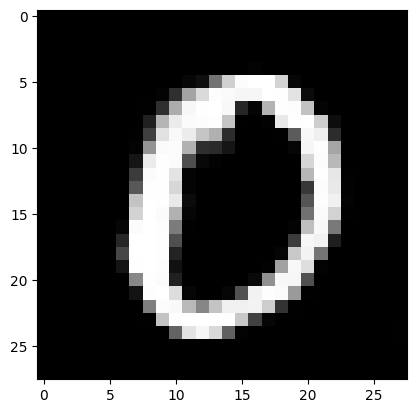

Epoch 9800/10000, Adversial Loss: -2.3507, Generator Loss: -3.1596
torch.Size([1, 1, 28, 28])


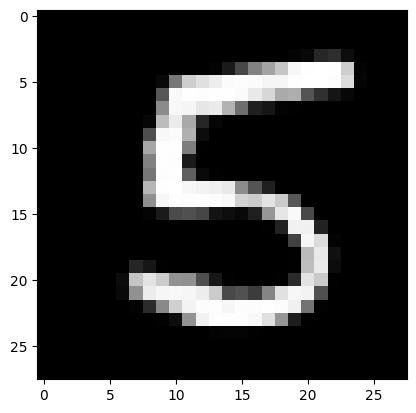

Epoch 9900/10000, Adversial Loss: -2.0559, Generator Loss: -2.3188
torch.Size([1, 1, 28, 28])


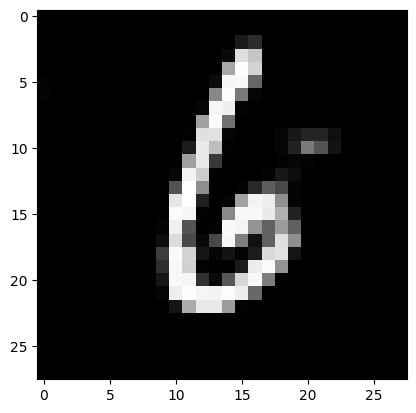

Epoch 10000/10000, Adversial Loss: -1.7913, Generator Loss: -2.0287


In [20]:
learning_rate = 1e-3
k = 5

lambda_gp = 10

# less epoch as can easily overfit
num_epoch = 10000

lossi_gen = []
lossi_adv = []

total_samples = len(train_loader)

advOptimizer = torch.optim.AdamW(adv.parameters(), lr=learning_rate, betas=(0.0, 0.9))
generatorOptimizer = torch.optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.0, 0.9))

generator = generator.to(device)
generator = nn.DataParallel(generator)

adv = adv.to(device)
adv = nn.DataParallel(adv)

train_loader_iter_adv_training = itertools.cycle(iter(train_loader))

for epoch in range(num_epoch):
    adv.train()
    generator.eval()
    
    for _ in range(k):
        advOptimizer.zero_grad()
        
        feature, _ = next(train_loader_iter_adv_training)
        feature = feature.to(device)
        # print(f"feature: {feature}")
        # print(f"feature.shape: {feature.shape}")

        pred_data = adv(feature)
        # print(f"pred_data: {pred_data}")
        # print(f"pred_data.shape: {pred_data.shape}")

        noise = torch.randn(batch_size, 100)
        noise = noise.to(device)
        # print(f"noise: {noise}")
        # print(f"noise.shape: {noise.shape}")
    
        gen_data = generator(noise)
        # print(f"gen_data: {noise}")
        # print(f"gen_data.shape: {gen_data.shape}")
        
        pred_gen_data = adv(gen_data)
        # print(f"pred_gen_data: {pred_gen_data}")
        # print(f"pred_gen_data.shape: {pred_gen_data.shape}")

        # loss
        gp = gradientPenalty(feature, gen_data, adv)
        advLoss = adversarialLoss(pred_data, pred_gen_data, gp, lambda_gp)

        advLoss.backward()
        advOptimizer.step()

        lossi_adv.append(advLoss.detach().cpu())

    generatorOptimizer.zero_grad()

    adv.eval()
    generator.train()

    noise = torch.randn(batch_size, 100)
    noise = noise.to(device)
    # print(f"noise: {noise}")
    # print(f"noise.shape: {noise.shape}")

    gen_data = generator(noise)
    # print(f"gen_data: {noise}")
    # print(f"gen_data.shape: {gen_data.shape}")

    pred_gen_data = adv(gen_data)
    # print(f"pred_gen_data: {pred_gen_data}")
    # print(f"pred_gen_data.shape: {pred_gen_data.shape}")
    
    # loss
    genLoss = generatorLoss(pred_gen_data)

    genLoss.backward()
    generatorOptimizer.step()

    lossi_gen.append(genLoss.detach().cpu())

    if ((epoch+1)%100==0):
        generator.eval()

        with torch.no_grad():
            noise = torch.randn(1,100)
            noise = noise.to(device)
            
            gen_img = generator(noise)
            print(gen_img.shape)
            img = gen_img.view(1, 28, 28)
            
            plt.imshow(img.squeeze().cpu(), cmap="gray")
            plt.show()

        print(f"Epoch {epoch+1}/{num_epoch}, Adversial Loss: {advLoss.item():.4f}, Generator Loss: {genLoss.item():.4f}")

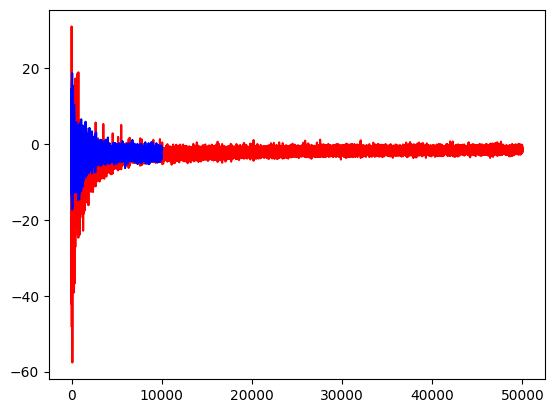

In [21]:
plt.plot(lossi_adv, c="red")
plt.plot(lossi_gen, c="blue")

torch.Size([1, 1, 28, 28])


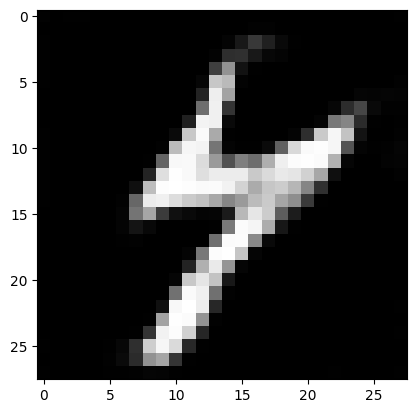

In [22]:
generator.eval()

with torch.no_grad():
    noise = torch.randn(1,100)
    noise = noise.to(device)
    
    gen_img = generator(noise)
    print(gen_img.shape)
    img = gen_img.view(1, 28, 28)
    
    plt.imshow(img.squeeze().cpu(), cmap="gray")
    plt.show()